# Segmenting and Clustering Neighborhoods in Toronto

***
## 1. Toronto Postal Code Areas

### Import required libraries

In [1]:
# HTML Data Parser
from bs4 import BeautifulSoup as bs

# Library to handle data ina vectorised manner
import numpy as np

# Data Analysis library
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Process JSON files
import json

# Geocoding - convert address to latitude and longitude
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

# Handle requests
import requests


# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 


# K-Means Clustering
from sklearn.cluster import KMeans

# Map Rendering
!conda install -c conda-forge folium=0.5.0 --yes
import folium


# standardizing the data
from sklearn.preprocessing import StandardScaler


print('Required Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### Retrieve data Data from web page

In [2]:
# url of web page containing data
page = requests.get('http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

# create blank lists to store data, Post Code, Borough & Beighbourhood
listpcode = []
listboro = []
listnei = []

# create Beautiful Soup instance to parse data
soup = bs(page.content, 'html.parser')

# identify html table that holds the data on web page
table = soup.find('table', {"class" : "wikitable sortable"})

# loop through each table row (tr) and append data held in each cell (td) to approrpiate list
for row in table.find_all('tr'): 
        
        cols = row.find_all('td')
        
        # if number of columns is 3 as excpected append to list
        if len(cols) == 3: 
            listpcode.append((cols[0].text.strip()))
            listboro.append((cols[1].text.strip()))
            listnei.append((cols[2].text.strip()))

# Check lists all of same length            
print("List of Postcodes is " + str(len(listpcode)))
print("List of Boroughs is " + str(len(listboro)))
print("List of Neighbourhoods is " + str(len(listnei)))         
            

List of Postcodes is 288
List of Boroughs is 288
List of Neighbourhoods is 288


### Create Data Frame

In [3]:
# Combine lists togther
ziplist = list(zip(listpcode, listboro, listnei))

# Create Data Frame. Assign Column Headings
df =pd.DataFrame(ziplist, columns = ['PostalCode' , 'Borough', 'Neighbourhood'])
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Check data types (all Strings)

In [4]:
print(df.dtypes)

PostalCode       object
Borough          object
Neighbourhood    object
dtype: object


### Remove rows where Borough is "Not assigned"

In [5]:
# drop Not assigned in Borough

todrop = df[df['Borough'] == "Not assigned"].index

df.drop(todrop, inplace=True)


df.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Set unassigned Neighborhood cells set to the postcode Borough name 

In [6]:
# Update not assigned neighbourhood to the Borough name
df.loc[df['Neighbourhood'] == "Not assigned", ['Neighbourhood']] = df['Borough']

df.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Combine Post Code areas with mutilple neighbourhoods to single postcode containing multiple Neighbourhoods

In [7]:
# combine rows,  use lambda function to join text on each aggregation
concat = lambda c: ", ".join(c)

df = pd.DataFrame(df.groupby(by='PostalCode').agg({'Borough': 'first', 'Neighbourhood': concat}).reset_index())

df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Print shape of Dataframe

In [8]:
df.shape

(103, 3)

***
# 2. Geocode Post Code Areas

### Download CSV File
File downloaded and stored in Object Storage. Credential details not shown.

In [11]:
body = client_details.get_object(Bucket='ibmdatasciencecapstoneproject-donotdelete-pr-lasbzyz1xlweje',Key='Geospatial_Coordinates.csv')['Body']

### Create DataFrame from data

In [12]:
df_data_0 = pd.read_csv(body)

### Merge DataFrames to combine Post Code data with geospatial coordinates

In [13]:
# Merge Data Frames using Post Code as lookup value
dfdata = pd.merge(left=df,right=df_data_0, left_on='PostalCode', right_on='Postal Code')

# Sort DataFrame 
dfdata = dfdata.sort_values(by ='PostalCode')

# Delete duplicated Post Code column
del dfdata['Postal Code']

#check number of rows is the same as before merge
dfdata.shape

(103, 5)

### Display the DataFrame

In [14]:
dfdata

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


***
# 3. Exploration and Clustering of the Neighborhoods in Toronto

### Set Latitude and Longitude of Toronto

In [15]:
# Toronto
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The Latitude and Logitude of Toronto are {}, {}.'.format(latitude, longitude))

The Latitude and Logitude of Toronto are 43.653963, -79.387207.


### Generate Folium Map showing all Post Code centroids

In [16]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add pins to map
for pcode, lat, lng, borough, neighborhood in zip(dfdata['PostalCode'],dfdata['Latitude'], dfdata['Longitude'], dfdata['Borough'], dfdata['Neighbourhood']):
    label = '{}, {}, {}'.format(pcode, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

### Create DataFrame showing only Boroughs containing "Toronto"

In [18]:
toronto_data = dfdata[dfdata['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data



,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


### Generate Map showing Toronto Boroughs

In [19]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for pcode, lat, lng, borough, neighborhood in zip(toronto_data['PostalCode'],toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}, {}'.format(pcode, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

### Input FourSquare Credentials.
FourSqaure to be used to retrieve details of venues in each Neighbourhood (credentials hidden)

In [21]:
# Set limit of venues brough back by Foursquare on each search 

LIMIT = 100

### Define function to return a Data Frame containing venues for each Neighbourhood

In [22]:
# Function to retrieve venue details for each set of coordinates and return a dataframe containg vevue information.
# Radius of search is 500m

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    

    # generate Data Frame    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)            

### Create Venue Data Frame using function

In [23]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                latitudes=toronto_data['Latitude'],
                                longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

### Examine DataFrame

In [24]:
print(toronto_venues.shape)
toronto_venues.head()

(1724, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


### Investigate how many unique venue categories exist

In [25]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 240 unique categories.


### Create column for each venue category using one hot encoding
ie set value of 1 if location matches category, 0 if not

In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
# toronto_onehot.shape

### Genrate new DataFrame grouped Neighbourhood

In [33]:
# group by Neighbourhood using mean to get average 



toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

#toronto_grouped = toronto_onehot.groupby('Neighborhood').count().reset_index()

toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.010000,0.010000,0.000000,0.030000,0.0000,0.000000,0.000000,0.0000,0.000000,0.010000,0.000000,0.040000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.020000,0.000000,0.000000,0.01,0.030000,0.010000,0.000000,0.000000,0.050000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.070000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0

### Check shape ie number of Neighbourhoods

In [34]:
toronto_grouped.shape

(38, 240)

### Define function to bring back n most common venues in neighbourhood

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create Data Frame containing 10 most frequent venues 

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Bar,Asian Restaurant,Restaurant,Hotel,Steakhouse,Burger Joint
1,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Bakery,Steakhouse,Seafood Restaurant,Farmers Market,Cheese Shop,Café,Park
2,"Brockton, Exhibition Place, Parkdale Village",Café,Breakfast Spot,Coffee Shop,Gym,Restaurant,Bar,Stadium,Burrito Place,Sandwich Place,Caribbean Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Plane,Coffee Shop,Boat or Ferry,Sculpture Garden,Boutique,Bar,Airport Gate


### Standardize the Data

In [76]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(toronto_grouped_clustering)


### Create DataFrame to be used for K-Means Clustering

In [40]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

### Utilise 'Elbow Method' to determine number of clusters to be used

Text(0, 0.5, 'Inertia')

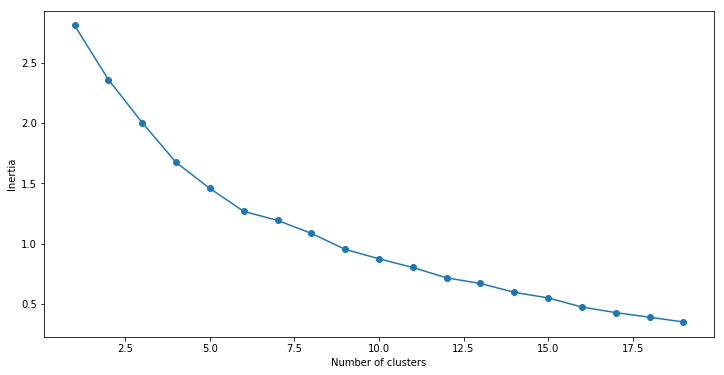

In [41]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    #kmeans.fit(data_scaled)
    kmeans.fit(toronto_grouped_clustering)
    SSE.append(kmeans.inertia_)

    
import matplotlib.pyplot as plt
%matplotlib inline    
    
    
    
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### Perform K-Means using 6 Clusters
6 chosen as this is where the line of the graph above changes gradient

In [62]:
# set number of clusters
kclusters = 6

#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Add clustering Labels to Venues data and Combine with Toronto DataFrame

In [66]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Pub,Trail,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Sandwich Place,Burger Joint,Italian Restaurant,Steakhouse,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant,Brewery,Burrito Place
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Comfort Food Restaurant,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Swim School,Bus Line,Women's Store,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,Food & Drink Shop,Park,Sandwich Place,Clothing Store,Hotel,Dog Run,Gym,Breakfast Spot,Event Space,Ethiopian Restaurant
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Sporting Goods Shop,Clothing Store,Coffee Shop,Yoga Studio,Gift Shop,Mexican Restaurant,Diner,Dessert Shop,Cosmetics Shop,Park
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1,Dessert Shop,Sandwich Place,Gym,Café,Coffee Shop,Pizza Place,Thai Restaurant,Sushi Restaurant,Italian Restaurant,Farmers Market
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2,Playground,Gym,Summer Camp,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,0,Pub,Coffee Shop,Pizza Place,Liquor Store,Light Rail Station,Sports Bar,Restaurant,Bagel Shop,Supermarket,Sushi Restaurant


### Display clusters on Map

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Display Cluster 1

In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Health Food Store,Pub,Trail,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
9,Central Toronto,0,Pub,Coffee Shop,Pizza Place,Liquor Store,Light Rail Station,Sports Bar,Restaurant,Bagel Shop,Supermarket,Sushi Restaurant


### Display Cluster 2

In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
2,East Toronto,1,Park,Sandwich Place,Burger Joint,Italian Restaurant,Steakhouse,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant,Brewery,Burrito Place
3,East Toronto,1,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Comfort Food Restaurant,Brewery,Seafood Restaurant,Sandwich Place
5,Central Toronto,1,Food & Drink Shop,Park,Sandwich Place,Clothing Store,Hotel,Dog Run,Gym,Breakfast Spot,Event Space,Ethiopian Restaurant
6,Central Toronto,1,Sporting Goods Shop,Clothing Store,Coffee Shop,Yoga Studio,Gift Shop,Mexican Restaurant,Diner,Dessert Shop,Cosmetics Shop,Park
7,Central Toronto,1,Dessert Shop,Sandwich Place,Gym,Café,Coffee Shop,Pizza Place,Thai Restaurant,Sushi Restaurant,Italian Restaurant,Farmers Market
11,Downtown Toronto,1,Coffee Shop,Park,Grocery Store,Café,Italian Restaurant,Bakery,Restaurant,Pub,Pizza Place,Pharmacy
12,Downtown Toronto,1,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Burger Joint,Fast Food Restaurant,Pub,Gym,Gastropub
13,Downtown Toronto,1,Coffee Shop,Park,Bakery,Café,Pub,Restaurant,Breakfast Spot,Mexican Restaurant,Theater,Beer Store
14,Downtown Toronto,1,Coffee Shop,Clothing Store,Cosmetics Shop,Italian Restaurant,Café,Middle Eastern Restaurant,Fast Food Restaurant,Ice Cream Shop,Sporting Goods Shop,Bubble Tea Shop


### Display Cluster 3

In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,2,Playground,Gym,Summer Camp,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


### Display Cluster 4

In [71]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,3,Park,Swim School,Bus Line,Women's Store,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


### Display Cluster 5

In [72]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,4,Park,Playground,Trail,Building,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
23,Central Toronto,4,Trail,Jewelry Store,Sushi Restaurant,Park,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Women's Store


### Display Cluster 6

In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,5,Health & Beauty Service,Home Service,Garden,Women's Store,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


*** 

### Concusion

Cluster 1 : Coffee Shops, Pubs

Cluster 2 : Restaurants, Cafes, Bars

Cluster 3 : Playgrounds, Gyms

Cluster 4 : Parks, Swimmming

Cluster 5 : Parks, Trails, Play Areas

Cluster 6 : Services eg Heath & Beauty, Home Services
